In [1]:
import sys
sys.path.append('../')
import LoadIntoDf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

In [2]:


# Load the data
df = LoadIntoDf.load_sqlite_data_smaller(3)
print('data loaded')

# Split data into features and labels
X = df.drop('difficulty', axis=1).values
y = df.difficulty.str.split('/').str[0]


categories = ['4a', '4b', '4c', 
'5a', '5b', '5c', 
'6a', '6a+', '6b', '6b+', '6c', '6c+', 
'7a', '7a+', '7b', '7b+', '7c', '7c+', 
'8a', '8a+', '8b', '8b+', '8c']

encoder = OrdinalEncoder(categories=[categories])

y = encoder.fit_transform(y.values.reshape(-1, 1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data loaded


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using device: cuda


In [6]:


# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.l2_reg = 0.001  # L2 regularization factor

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.dropout(out)
        out = self.relu(self.layer2(out))
        out = self.dropout(out)
        out = self.relu(self.layer3(out))
        out = self.dropout(out)
        out = self.layer4(out)
        return out
    

In [7]:

input_size = X_train.shape[1]

model = NeuralNet(input_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=model.l2_reg)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)



/home/isitar/Projects/cas-data-science/00_Projektarbeit/cas-project/lib64/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:


# Training the model
num_epochs = 500
losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
         # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
      
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        #if i % 500 == 0:
        #    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    if epoch % 50 == 0:
        model_path = 'model_epoch_{}.pt'.format(epoch)
        torch.save(model.state_dict(), model_path)
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.savefig(f"nn_learning_curve_epoch_{epoch+1}.pdf")
        plt.close()



Epoch [1/500], Loss: 13.0344, Validation Loss: 5.7265
Epoch [2/500], Loss: 9.8143, Validation Loss: 5.5636
Epoch [3/500], Loss: 8.8045, Validation Loss: 5.9008
Epoch [4/500], Loss: 8.5928, Validation Loss: 5.4173
Epoch [5/500], Loss: 8.0477, Validation Loss: 4.6210
Epoch [6/500], Loss: 6.9786, Validation Loss: 4.9648
Epoch [7/500], Loss: 6.4835, Validation Loss: 4.2812
Epoch [8/500], Loss: 5.9305, Validation Loss: 4.0744
Epoch [9/500], Loss: 5.7625, Validation Loss: 4.9794
Epoch [10/500], Loss: 6.0819, Validation Loss: 5.1010
Epoch [11/500], Loss: 5.6606, Validation Loss: 4.2005
Epoch [12/500], Loss: 5.2211, Validation Loss: 4.0520
Epoch [13/500], Loss: 5.0806, Validation Loss: 4.0362
Epoch [14/500], Loss: 5.1344, Validation Loss: 3.6190
Epoch [15/500], Loss: 4.6939, Validation Loss: 3.5630
Epoch [16/500], Loss: 4.6546, Validation Loss: 4.3048
Epoch [17/500], Loss: 4.8005, Validation Loss: 3.5053
Epoch [18/500], Loss: 4.3807, Validation Loss: 3.6893
Epoch [19/500], Loss: 4.3172, Valida

In [7]:

plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig(f"nn_learning_curve_epoch_{epoch+1}.pdf")
plt.close()
# Evaluate the model
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    test_mse = mean_squared_error(y_true, y_pred)
    test_mae = mean_absolute_error(y_true, y_pred)
    test_mape = mean_absolute_percentage_error(y_true+1, y_pred+1)
    test_r2 = r2_score(y_true, y_pred)
    print(f'Test MSE: {test_mse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test MAPE: {test_mape:.4f}')
    print(f'Test R2: {test_r2:.4f}')

Test MSE: 2.9150
Test MAE: 1.2868
Test MAPE: 0.2250
Test R2: 0.8523


In [18]:
np.min(y_pred)

-0.08465958

20.0

In [23]:
y_pred = np.clip(y_pred, 0, 20)
y_pred_back = encoder.inverse_transform(y_pred + 1)
y_test_back = encoder.inverse_transform(y_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_back, y_pred_back)

0.2572796560484659

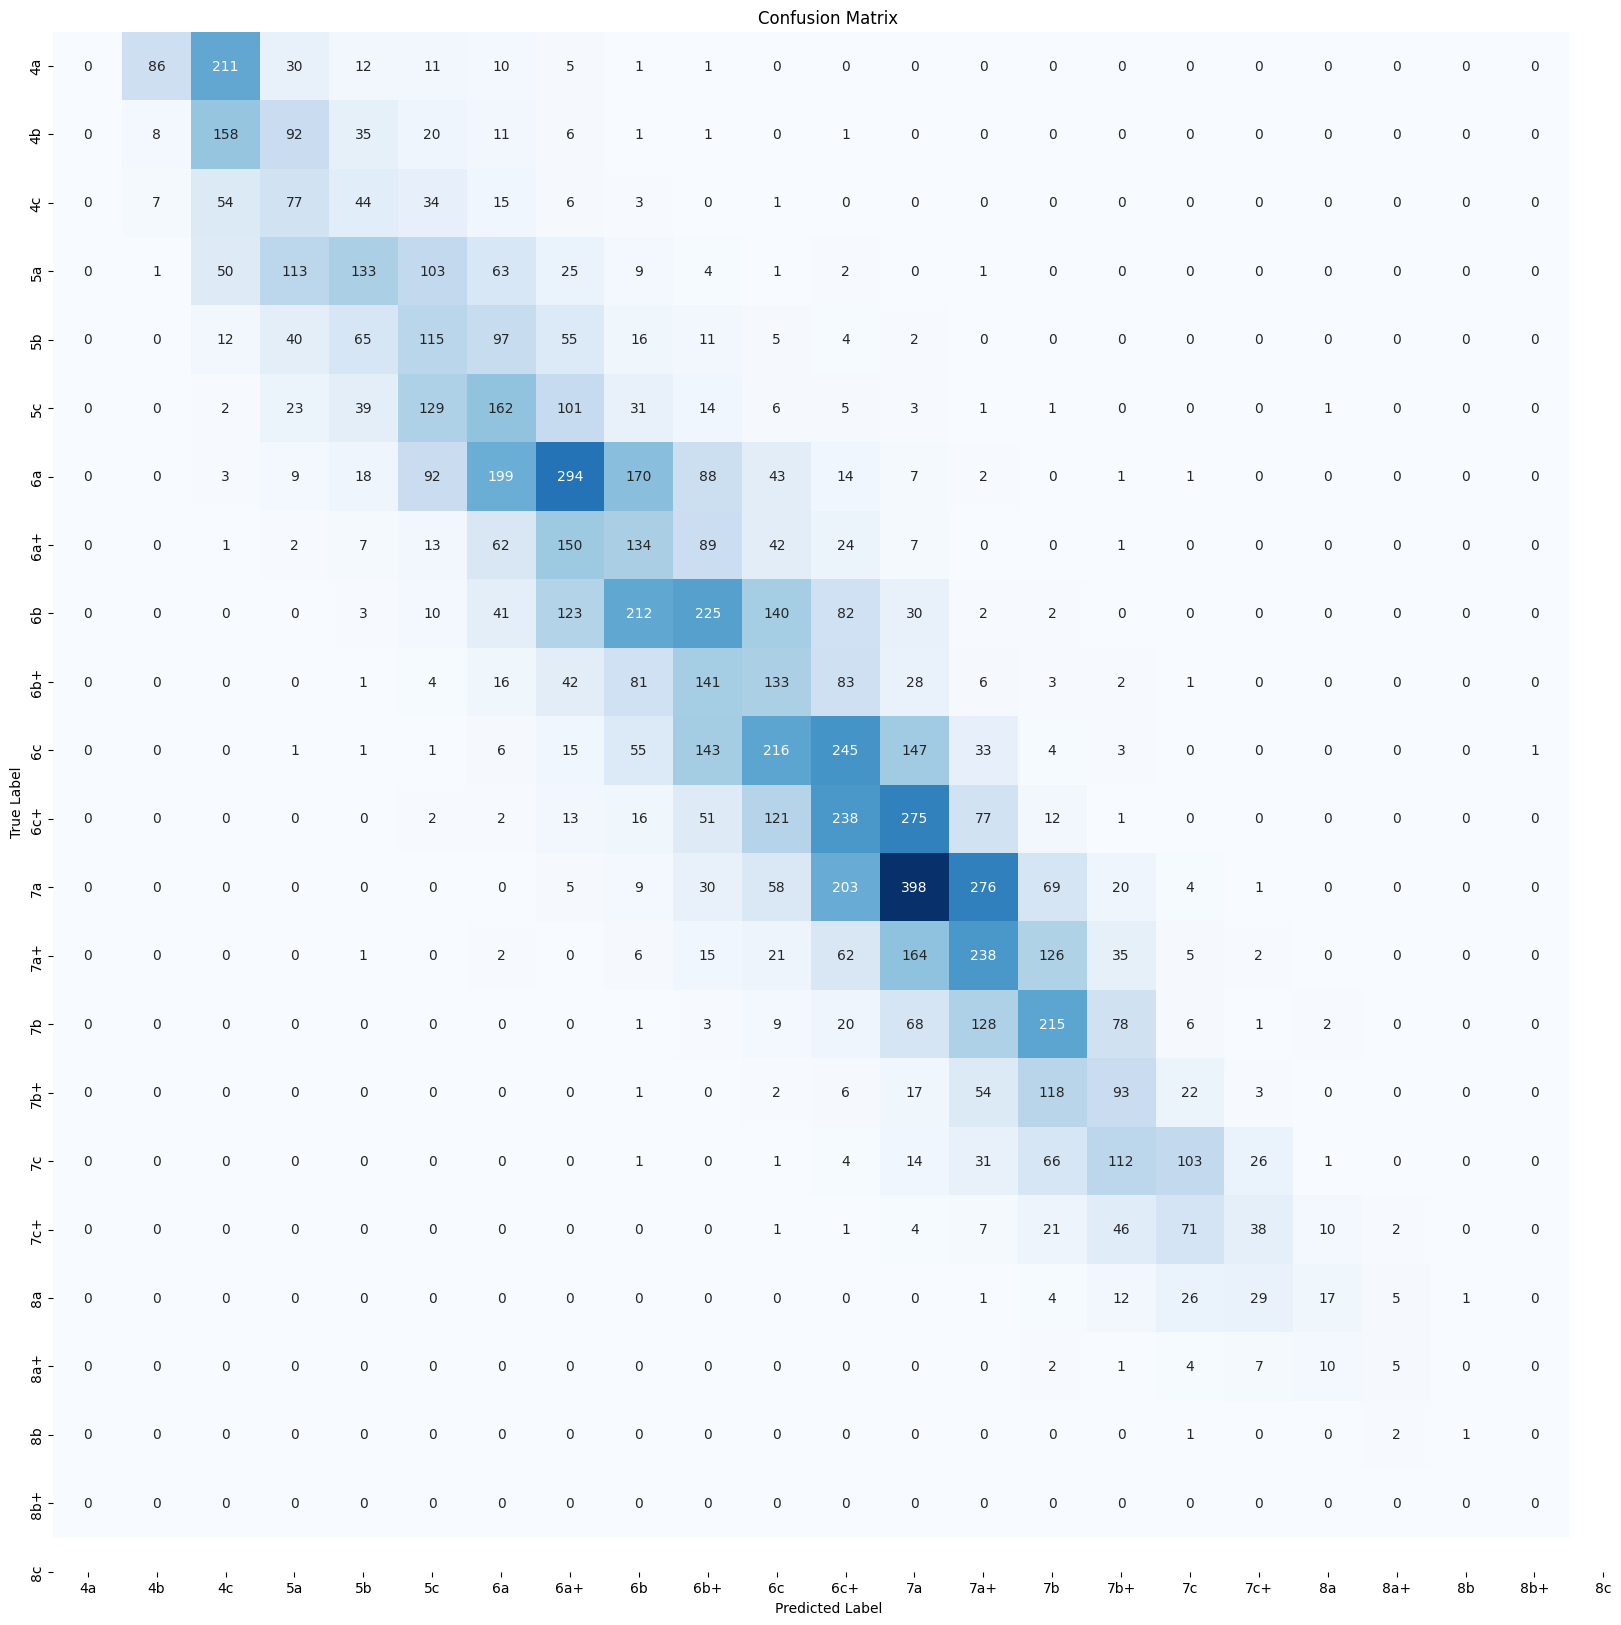

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_back, y_pred_back)
class_labels = categories

# Plot confusion matrix
plt.figure(figsize=(20, 20))  # Adjust the size here

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')
plt.show()


In [ ]:
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 0, 14)

In [ ]:
y_pred_back = encoder.inverse_transform(y_pred)
y_test_back = encoder.inverse_transform(y_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_back, y_pred_back)

0.2317252092862691

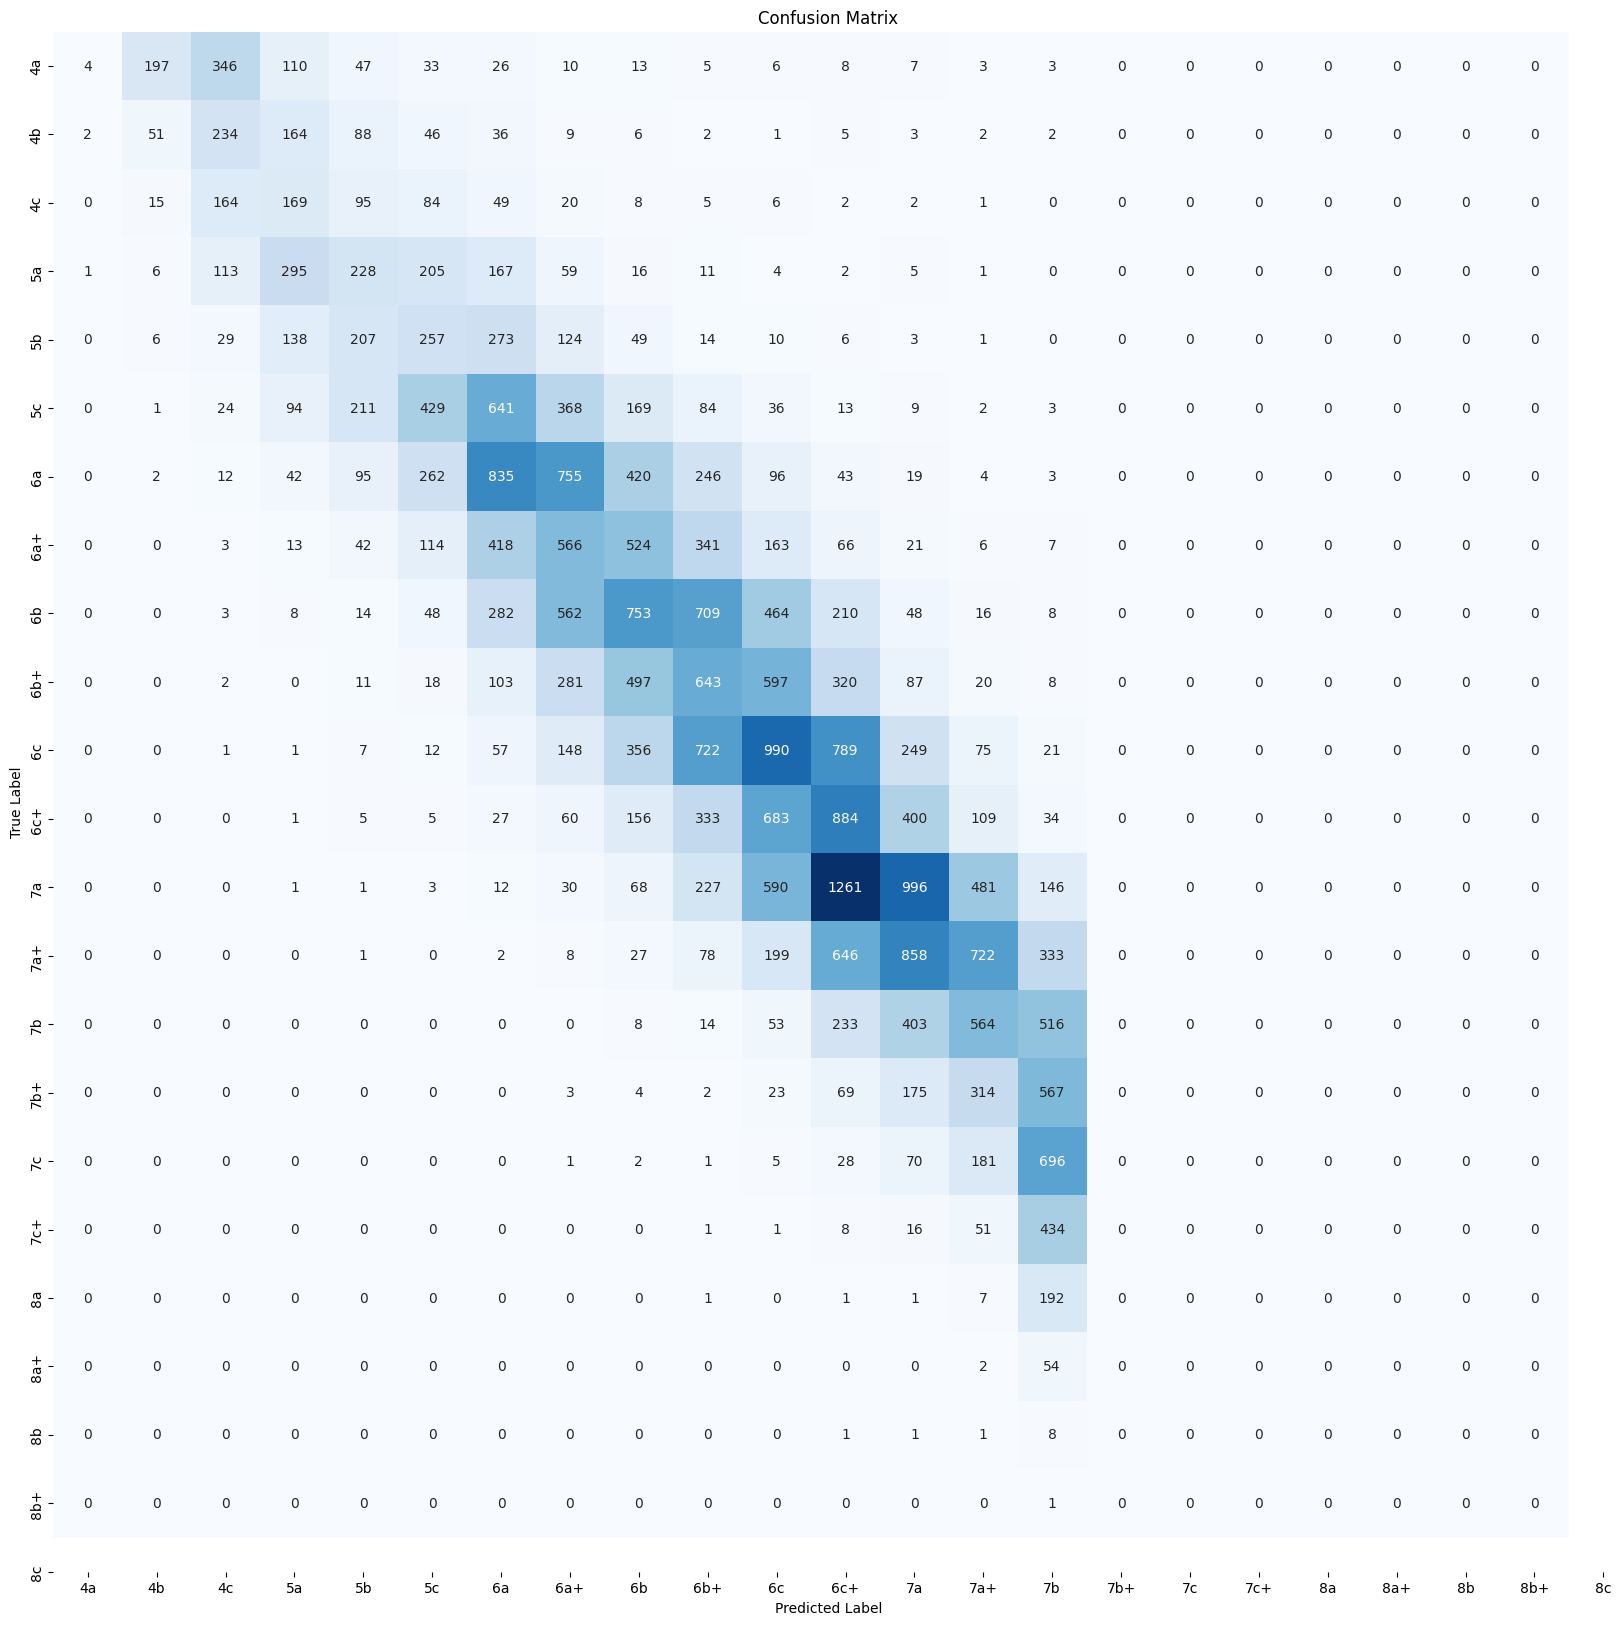

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_back, y_pred_back)
class_labels = categories

# Plot confusion matrix
plt.figure(figsize=(20, 20))  # Adjust the size here

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix2.pdf', bbox_inches='tight')
plt.show()


In [3]:


# Load the data
df = LoadIntoDf.load_sqlite_data_smaller(3)
print('data loaded')

# Split data into features and labels
X = df.drop('difficulty', axis=1).values
y = df.difficulty.str.split('/').str[0]
y = y.str.replace('+', '')


categories = ['4a', '4b', '4c', 
'5a', '5b', '5c', 
'6a', '6b', '6c', 
'7a', '7b', '7c', 
'8a', '8b', '8c']

encoder = OrdinalEncoder(categories=[categories])

y = encoder.fit_transform(y.values.reshape(-1, 1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data loaded


array([[ 3.],
       [ 8.],
       [ 7.],
       ...,
       [11.],
       [ 8.],
       [ 8.]])

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using device: cuda


In [10]:


# Training the model
num_epochs = 250
losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
         # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
      
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        #if i % 500 == 0:
        #    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    if epoch % 50 == 0:
        model_path = 'model_epoch_{}.pt'.format(epoch)
        torch.save(model.state_dict(), model_path)
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.savefig(f"nn_simpl_learning_curve_epoch_{epoch+1}.pdf")
        plt.close()


    

Epoch [1/250], Loss: 0.8696, Validation Loss: 1.2168
Epoch [2/250], Loss: 0.8558, Validation Loss: 1.2133
Epoch [3/250], Loss: 0.8469, Validation Loss: 1.2176
Epoch [4/250], Loss: 0.8602, Validation Loss: 1.2167
Epoch [5/250], Loss: 0.8531, Validation Loss: 1.2141
Epoch [6/250], Loss: 0.8511, Validation Loss: 1.2169
Epoch [7/250], Loss: 0.8520, Validation Loss: 1.2179
Epoch [8/250], Loss: 0.8673, Validation Loss: 1.2172
Epoch [9/250], Loss: 0.8492, Validation Loss: 1.2164
Epoch [10/250], Loss: 0.8515, Validation Loss: 1.2149
Epoch [11/250], Loss: 0.8525, Validation Loss: 1.2148
Epoch [12/250], Loss: 0.8451, Validation Loss: 1.2160
Epoch [13/250], Loss: 0.8437, Validation Loss: 1.2146
Epoch [14/250], Loss: 0.8484, Validation Loss: 1.2158
Epoch [15/250], Loss: 0.8443, Validation Loss: 1.2141
Epoch [16/250], Loss: 0.8536, Validation Loss: 1.2149
Epoch [17/250], Loss: 0.8410, Validation Loss: 1.2155
Epoch [18/250], Loss: 0.8560, Validation Loss: 1.2159
Epoch [19/250], Loss: 0.8510, Validat

In [24]:

plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig(f"nn_learning_curve_epoch_{epoch+1}.pdf")
plt.close()
# Evaluate the model
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    test_mse = mean_squared_error(y_true, y_pred)
    test_mae = mean_absolute_error(y_true, y_pred)
    test_mape = mean_absolute_percentage_error(y_true+1, y_pred+1)
    test_r2 = r2_score(y_true, y_pred)
    print(f'Test MSE: {test_mse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test MAPE: {test_mape:.4f}')
    print(f'Test R2: {test_r2:.4f}')

Test MSE: 1.2149
Test MAE: 0.8097
Test MAPE: 0.1740
Test R2: 0.8443


In [19]:
y_pred

array([[5.0505605],
       [9.592796 ],
       [8.448856 ],
       ...,
       [7.8150725],
       [8.816572 ],
       [6.2321024]], dtype=float32)

In [31]:
y_pred_r = np.round(y_pred);
print(f"{y_pred_r=}")
print(f"{len(encoder.categories_[0])=}")
y_pred_r = np.clip(y_pred_r, 0, len(encoder.categories_[0]))
y_pred_back = encoder.inverse_transform(y_pred_r)
y_test_back = encoder.inverse_transform(y_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_back, y_pred_back)


y_pred_r=array([[ 5.],
       [10.],
       [ 8.],
       ...,
       [ 8.],
       [ 9.],
       [ 6.]], dtype=float32)
len(encoder.categories_[0])=15


0.4186046511627907

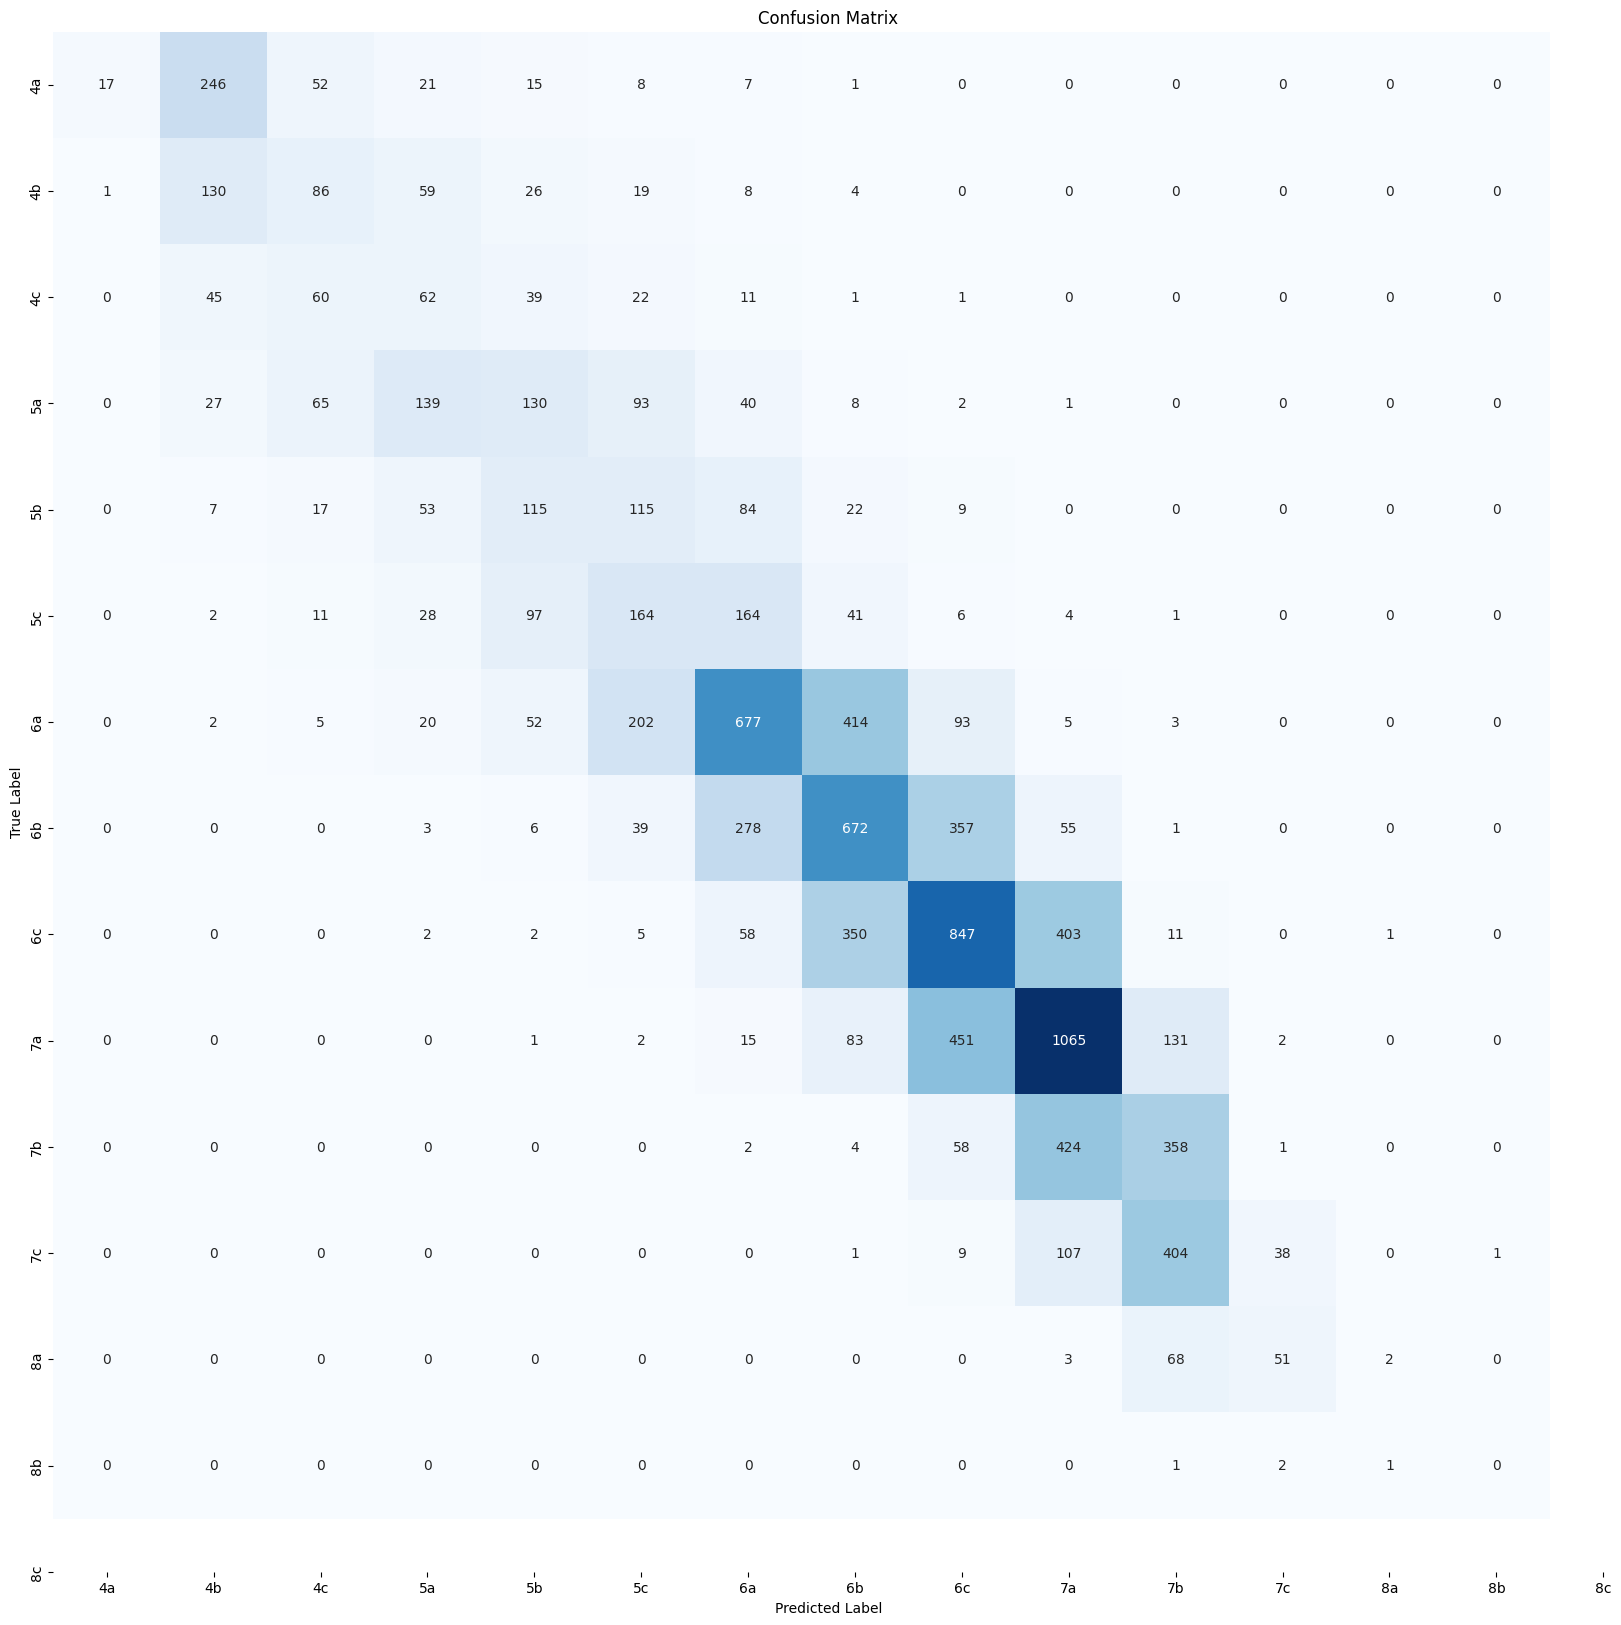

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_back, y_pred_back)
class_labels = categories

# Plot confusion matrix
plt.figure(figsize=(20, 20))  # Adjust the size here

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_simplified.pdf', bbox_inches='tight')
plt.show()
